In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [104]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

## 1. Import the data

In [29]:
df = pd.read_csv("../input/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [31]:
# Transform TotalCharges into numeric 
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors = 'coerce')

In [32]:
# Checking SeniorCitizen 
df.SeniorCitizen.describe()

count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SeniorCitizen, dtype: float64

In [33]:
# check the number of NAs for each columns
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [34]:
# Drop NAs
df = df.dropna()

## 2. Data Exploratory

We can divide variables into two kinds: Continuous variables and Discontious varibles (which also means binary case). Let's check the binary cases first. 

In [35]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [36]:
# Checking SeniorCitizen 
df.SeniorCitizen.describe()

count    7032.000000
mean        0.162400
std         0.368844
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SeniorCitizen, dtype: float64

In [37]:
# Get the list of variables into two groups
X_numeric = df.columns[df.dtypes != 'object'].tolist()
X_binary = df.columns[df.dtypes == 'object'].tolist()

print("There are {} numeric variables with {}".format(len(X_numeric), X_conti))
print("There are {} binary variables with {}".format(len(X_binary), X_binary))

There are 4 numeric variables with ['tenure', 'MonthlyCharges', 'TotalCharges']
There are 17 binary variables with ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [38]:
X_binary = X_binary[1:-1]
X_binary.append(X_numeric[0])
X_numeric = X_numeric[1:]

print("There are {} continous variables with {}".format(len(X_numeric), X_conti))
print("There are {} binary variables with {}".format(len(X_binary), X_binary))

There are 3 continous variables with ['tenure', 'MonthlyCharges', 'TotalCharges']
There are 16 binary variables with ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']


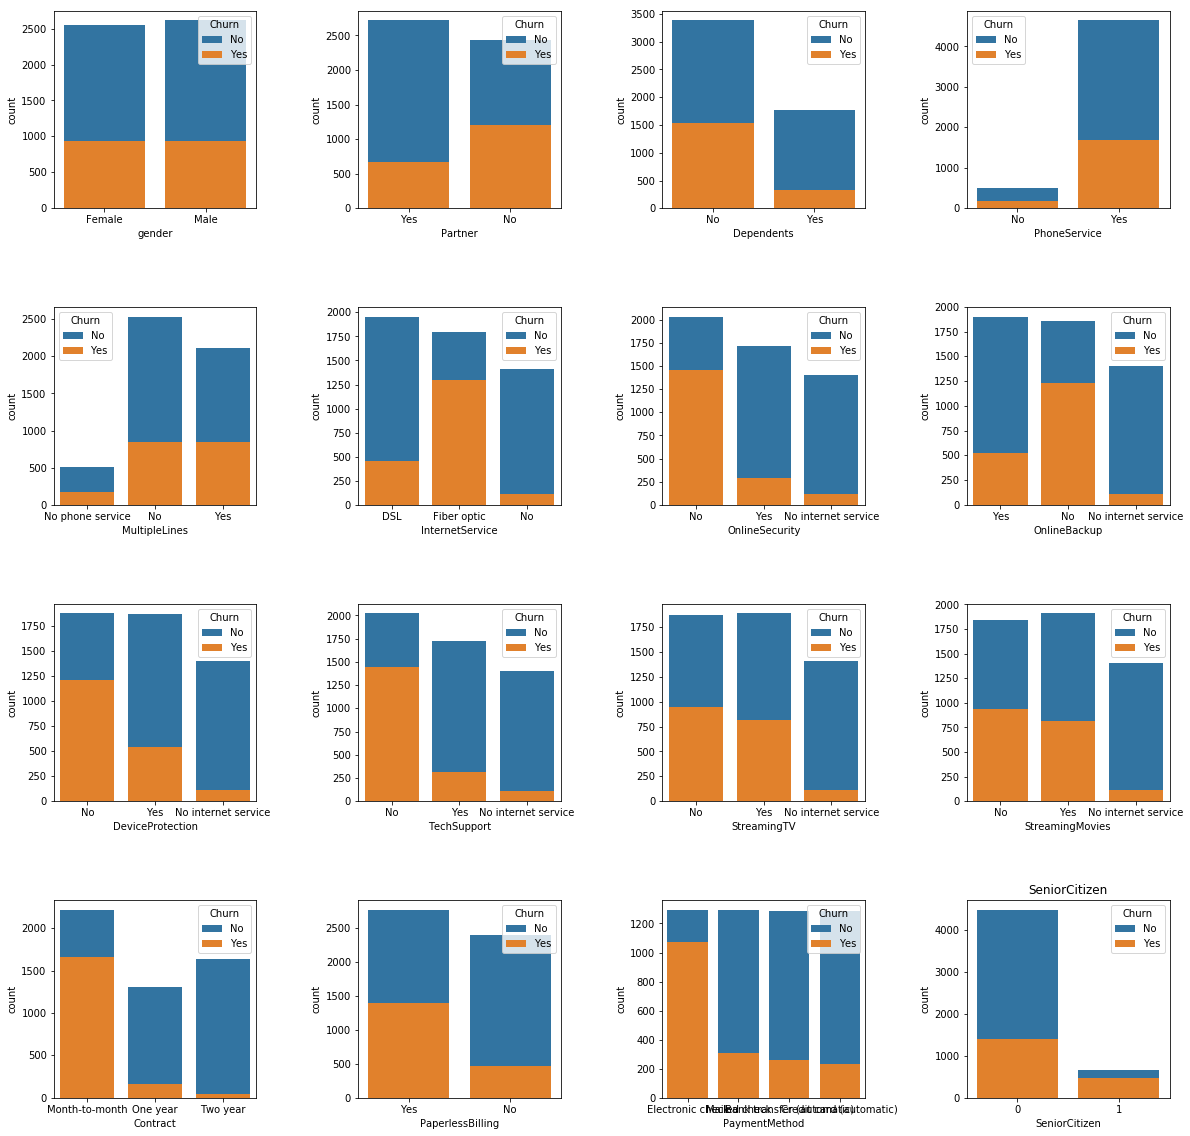

In [39]:
# The distribution of binary variables
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20))

for i in range(0, 16):
    ax = axes[i//4, i%4]
    sns.countplot(x = X_binary[i], data = df, hue = df.Churn, dodge = False, ax = ax)
    plt.subplots_adjust(wspace = .5, hspace = .5)
    plt.title(str(X_binary[i]))

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


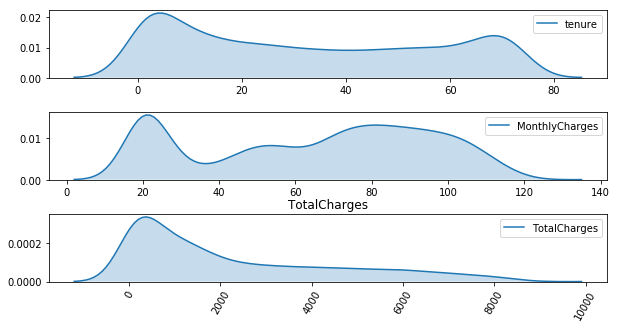

In [40]:
# The distribution of binary variables
fig, axes = plt.subplots(nrows = 3, figsize = (10, 5))

for i in range(0, 3):
    ax = axes[i]
    sns.kdeplot(df[X_numeric[i]], shade = 'b', ax = ax)
    plt.subplots_adjust(wspace = .5, hspace = .5)

## 3. Preprocessing

In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [42]:
# Encoding the target variable
labelencoder = LabelEncoder()
y = df.Churn
y = labelencoder.fit_transform(y)

In [44]:
# Drop the target variable
df = df.drop(['customerID','Churn'], axis = 1)

# Encoding the bianry variables
for i in X_binary:
    df[i] = labelencoder.fit_transform(df[i])
    
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65


In [46]:
# Standardize the numeric data
scaler = StandardScaler()
df[X_numeric] = scaler.fit_transform(df[X_numeric])

X = df
X.head()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

## 4, Modeling

In [90]:
model_dic = {'logistic': LogisticRegression(),
             'gaussian': GaussianNB(),
             'randomforest' : RandomForestClassifier(),
             'adaboost' : AdaBoostClassifier(),
             'gradientboost' : GradientBoostingClassifier(),
             'xgb' : XGBClassifier(objective = 'binary:logistic')}

In [95]:
pred_df = pd.DataFrame()
pred_df['actual'] = y_test

for index, val in enumerate(model_dic):
    clas = model_dic[val]
    clas.fit(X_train, y_train)
    pred = clas.predict(X_test)
    pred_df[val] = pred
    print(val, ": ", accuracy_score(y_test, pred))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


logistic :  0.7853589196872779
gaussian :  0.7377398720682303
randomforest :  0.7711442786069652
adaboost :  0.783226723525231
gradientboost :  0.7960199004975125
xgb :  0.7938877043354655


## 5. Modeling with Keras

In [103]:
input_node = X_train.shape[1]
input_node

19

In [112]:
# Initialize the model 
model = Sequential()

# Create hidden layers 
model.add(Dense(input_dim = input_node, output_dim = 10, activation = 'relu'))
model.add(Dense(output_dim = 5, activation= 'relu'))
model.add(Dense(output_dim = 1, activation= 'sigmoid'))

# Backpropagation
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Callbacks 
early_stopper = EarlyStopping(patience = 5)

# Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                200       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=19, activation="relu", units=10)`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=5)`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  import sys


In [116]:
# Fitting 
model.fit(X_train, y_train, batch_size = 10, epochs = 100, callbacks = [early_stopper]) 
y_pred_ann = model.predict_proba(X_test)

Epoch 1/50
5625/5625 [==============================] - 0s 30us/step - loss: 0.3800 - acc: 0.8220
Epoch 2/50
5625/5625 [==============================] - 0s 30us/step - loss: 0.3791 - acc: 0.8228
Epoch 3/50
  50/5625 [..............................] - ETA: 0s - loss: 0.5015 - acc: 0.7400

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/callbacks.py:841: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


5625/5625 [==============================] - 0s 32us/step - loss: 0.3789 - acc: 0.8222
Epoch 4/50
5625/5625 [==============================] - 0s 28us/step - loss: 0.3793 - acc: 0.8215
Epoch 5/50
5625/5625 [==============================] - 0s 26us/step - loss: 0.3790 - acc: 0.8222
Epoch 6/50
5625/5625 [==============================] - 0s 27us/step - loss: 0.3791 - acc: 0.8208
Epoch 7/50
5625/5625 [==============================] - 0s 31us/step - loss: 0.3788 - acc: 0.8215
Epoch 8/50
5625/5625 [==============================] - 0s 32us/step - loss: 0.3789 - acc: 0.8222
Epoch 9/50
5625/5625 [==============================] - 0s 31us/step - loss: 0.3785 - acc: 0.8210
Epoch 10/50
5625/5625 [==============================] - 0s 26us/step - loss: 0.3787 - acc: 0.8226
Epoch 11/50
5625/5625 [==============================] - 0s 27us/step - loss: 0.3785 - acc: 0.8206
Epoch 12/50
5625/5625 [==============================] - 0s 32us/step - loss: 0.3789 - acc: 0.8220
Epoch 13/50
5625/5625 [=====

In [132]:
model.predict(X_test)[:, 1]

IndexError: index 1 is out of bounds for axis 1 with size 1

In [123]:
pred_df['keras'] = y_pred_ann

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


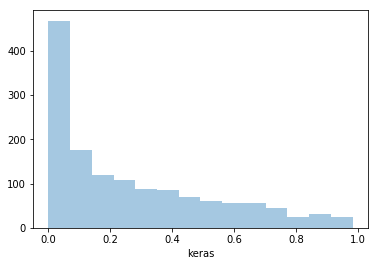

In [126]:
sns.distplot(pred_df.keras, kde = False)

* Referance :  [Kernel by Nilan](https://www.kaggle.com/nilanml/telecom-customer-churn-voting-80-1-accuracy)